In [1]:
import os, os.path
#os.environ["OPENBLAS_MAIN_FREE"] = "1"
import time
import signal
import multiprocessing as mp
import psutil
import os
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet152V2, VGG19,EfficientNetB2, InceptionResNetV2, NASNetLarge
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import zscore
from scipy import stats
from tensorflow.keras.callbacks import LearningRateScheduler
import xlsxwriter
import pandas as pd
from keras import backend as K
from keras.callbacks import CSVLogger
#from keras import regularizers
from tensorflow.keras import regularizers
from keras.layers import LeakyReLU

In [3]:
import os, os.path
#os.environ["OPENBLAS_MAIN_FREE"] = "1"
import time
import signal
import multiprocessing as mp
import psutil
import os
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet152V2, VGG19,EfficientNetB2, InceptionResNetV2, NASNetLarge
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import zscore
from scipy import stats
from tensorflow.keras.callbacks import LearningRateScheduler
import xlsxwriter
import pandas as pd
from keras import backend as K
from keras.callbacks import CSVLogger

dir_img='Real'
dir_lbl='Real'

img_folder="images_crop"
lbl_folder="labels_crop"

epochs=100
BATCH_SIZE=32
callbacks = []
schedule = None
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]   



def show_sample(train):
    data_samples = train.as_numpy_iterator()
    res = data_samples.next()

    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    for idx in range(4): 
        sample_image = res[0][idx]
        sample_coords = res[1][0][idx]
        
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:4], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[4:6], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[6:8], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[8:10], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[10:12], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[12:14], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[14:16], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[16:18], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[18:20], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[20:22], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[22:24], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[24:26], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[26:28], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[28:30], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[30:32], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[32:34], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[34:36], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[36:38], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[38:40], [250,250]).astype(int)), 2, (255,0,0), -1)
        cv2.circle(sample_image, tuple(np.multiply(sample_coords[40:42], [250,250]).astype(int)), 2, (255,0,0), -1)
        
        ax[idx].imshow(sample_image)

def prepare_image():
    train_images = tf.data.Dataset.list_files('E:/J#4/Data/Preprocessing/DS/AugDS/train/'+str(dir_img)+'/'+str(img_folder)+'/*.jpg', shuffle=False)
    train_images = train_images.map(load_image)
    #train_images = np.nan_to_num(zscore(train_images, axis=0))
    train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
    train_images = train_images.map(lambda x: x/255)

    test_images = tf.data.Dataset.list_files('E:/J#4/Data/Preprocessing/DS/OrigDS/test/Real/'+str(img_folder)+'/*.jpg', shuffle=False)
    test_images = test_images.map(load_image)
    #test_images = np.nan_to_num(zscore(test_images, axis=0))
    test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
    test_images = test_images.map(lambda x: x/255)


    val_images = tf.data.Dataset.list_files('E:/J#4/Data/Preprocessing/DS/OrigDS/val/Real/'+str(img_folder)+'/*.jpg', shuffle=False)
    val_images = val_images.map(load_image)
    #val_images = np.nan_to_num(zscore(val_images, axis=0))
    val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
    val_images = val_images.map(lambda x: x/255)

    print(len(train_images), len(test_images), len(val_images))
    return train_images,test_images,val_images

def prepare_label():
    train_labels = tf.data.Dataset.list_files('E:/J#4/Data/Preprocessing/DS/AugDS/train/'+str(dir_lbl)+'/'+str(lbl_folder)+'/*.json', shuffle=False)
    train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

    test_labels = tf.data.Dataset.list_files('E:/J#4/Data/Preprocessing/DS/OrigDS/test/Real/'+str(lbl_folder)+'/*.json', shuffle=False)
    test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

    val_labels = tf.data.Dataset.list_files('E:/J#4/Data/Preprocessing/DS/OrigDS/val/Real/'+str(lbl_folder)+'/*.json', shuffle=False)
    val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))
    return train_labels, test_labels, val_labels

def combine_labels_images(train_images, train_labels, test_images, test_labels, val_images, val_labels):
    train = tf.data.Dataset.zip((train_images, train_labels))
    train = train.shuffle(buffer_size=len(train_images))#reshuffle_each_iteration = False
    train = train.batch(BATCH_SIZE)
    #train = train.shuffle(buffer_size=len(train_images))
    train = train.prefetch(8)

    test = tf.data.Dataset.zip((test_images, test_labels))
    #test = test.shuffle(buffer_size=len(test_images))
    test = test.batch(BATCH_SIZE)
    test = test.prefetch(8)

    val = tf.data.Dataset.zip((val_images, val_labels))
    #val = val.shuffle(buffer_size=len(val_images))
    val = val.batch(BATCH_SIZE)
    val = val.prefetch(8)
    return train, test, val


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def custom_loss():        
    def NME(y_true, y_pred):                     
        #y_true = tf.cast(y_true, tf.int32)
        item = K.sqrt(K.sum(K.square(y_pred-y_true), axis=1))
        #_nme = K.mean(item)
        X_Min=10.0
        X_Max=-10.0
        Y_Min=10.0
        Y_Max=-10.0
        
        for kc in range (36):
            if kc%2==0: 
                X_Min=K.minimum(X_Min, y_true[:,kc])
                X_Max=K.maximum(X_Max, y_true[:,kc])
            else: 
                Y_Min=K.minimum(Y_Min, y_true[:,kc])
                Y_Max=K.maximum(Y_Max, y_true[:,kc])
        h = Y_Max-Y_Min+24
        w = X_Max-X_Min+18
        _dist = K.sqrt(h*w)
        temp1 = item/_dist
        _nme = K.mean(temp1)
        return _nme
    return NME

def custom_metric():        
    def MAPE(y_true, y_pred):                     
        item = K.sqrt(K.sum(K.square(y_pred-y_true), axis=1))
        _mape = K.mean(item)
        
        return _mape
    return MAPE



def correlation_metric(): 
    def PC(y_true, y_pred):
        numerator=K.sum((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))
        denominator=K.sqrt(K.sum(K.square(y_true - K.mean(y_true))))*K.sqrt(K.sum(K.square(y_pred - K.mean(y_pred))))
        _pc= numerator/denominator
        return _pc
    return PC

def mse_metric():
    def mse(y_true, y_pred):
        return K.mean(K.square(y_pred - y_true), axis=-1)
    return mse

def NMSE_metric(y_true, y_pred):
    nmse = K.square(y_true - y_pred)/K.square(y_true)
    return nmse 

In [5]:
def plot_performance(hist):
    global name1, epochs, name_ans
    print("********",name1,"********")
    N = len(hist.history['loss'])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), hist.history["loss"], label="Training MSE")
    plt.plot(np.arange(0, N), hist.history["val_loss"], label="Validation MSE")
    plt.plot(np.arange(0, N), hist.history["NME"], label="Training MAPE")
    plt.plot(np.arange(0, N), hist.history["val_NME"], label="Validation MAPE")#val_root_mean_squared_error
    plt.plot(np.arange(0, N), hist.history["PC"], label="Training Pearson_Correlation")
    plt.plot(np.arange(0, N), hist.history["val_PC"], label="Validation Pearson_Correlation")
    plt.plot(np.arange(0, N), hist.history["root_mean_squared_error"], label="Training RMSE")
    plt.plot(np.arange(0, N), hist.history["val_root_mean_squared_error"], label="Validation RMSE")
    #os.system("taskset -p 0xff %d" % os.getpid())
    #plt.title("Training Loss and Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Loss(MSE)/ Metric(NME, PC, RMSE)")
    plt.legend(loc="upper right")
    if name1=="resized":     plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_performance.png")
    else:  plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_performance_cropped.png")
    plt.show()
    plt.close()

    hist.history
    plt.style.use("ggplot")
    fig=plt.figure()
    plt.plot(hist.history['loss'], color='red', label='Training Loss')
    plt.plot(hist.history['val_loss'], color='blue', label='Validation Loss')
    #plt.suptitle('Loss', fontsize=20)
    plt.ylabel('Mean Squared Error Loss')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right")
    if name1=="resized":    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MSE.png")
    else: plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MSE_cropped.png")
    plt.show()
    plt.close()

    hist.history
    plt.style.use("ggplot")
    fig=plt.figure()
    plt.plot(hist.history['NME'], color='red', label='Training MAPE')
    plt.plot(hist.history['val_NME'], color='blue', label='Validation MAPE')
    #plt.suptitle('Accuracy', fontsize=20)
    plt.ylabel('Normalized Mean Error')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right")
    if name1=="resized":    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MAPE.png")
    else: plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MAPE_cropped.png")
    plt.show()
    plt.close()
    
    hist.history
    plt.style.use("ggplot")
    fig=plt.figure()
    plt.plot(hist.history['PC'], color='red', label='Training Pearson_Correlation')
    plt.plot(hist.history['val_PC'], color='blue', label='Validation Pearson_Correlation')
    #plt.suptitle('Accuracy', fontsize=20)
    plt.ylabel('Pearson Correlation Metric')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right")
    if name1=="resized":    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_PC.png")
    else: plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_PC_cropped.png")
    plt.show()
    plt.close()
    
    hist.history
    plt.style.use("ggplot")
    fig=plt.figure()
    plt.plot(hist.history['root_mean_squared_error'], color='red', label='Training RMSE')
    plt.plot(hist.history['val_root_mean_squared_error'], color='blue', label='Validation RMSE')
    #plt.suptitle('Accuracy', fontsize=20)
    plt.ylabel('Root Mean Squared Error Metric')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right")
    if name1=="resized":    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_RMSE.png")
    else: plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_RMSE_cropped.png")
    plt.show()
    plt.close()
    
    hist.history
    plt.style.use("ggplot")
    fig=plt.figure()
    plt.plot(hist.history['mean_absolute_error'], color='red', label='Training MAE')
    plt.plot(hist.history['val_mean_absolute_error'], color='blue', label='Validation MAE')
    #plt.suptitle('Accuracy', fontsize=20)
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right")
    if name1=="resized":    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MAE.png")
    else: plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MAE_cropped.png")
    plt.show()
    plt.close()

def plot_loss_time(hist, times, hist1, times1):
    global epochs, name_ans
    min_epoch=0
    if len(hist.history['loss'])<= len(hist1.history['loss']): min_epoch=len(hist.history['loss'])
    else: min_epoch=len(hist1.history['loss'])
                   
    N = min_epoch
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), hist.history["loss"], label="Training Resized_images")
    plt.plot(np.arange(0, N), hist.history["val_loss"], label="Validation Resized_images")
    plt.plot(np.arange(0, N), hist1.history["loss"], label="Training Cropped_resized_images")
    plt.plot(np.arange(0, N), hist1.history["val_loss"], label="Validation Cropped_resized_images")
    #os.system("taskset -p 0xff %d" % os.getpid())
    #plt.title("Training Loss and Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error Loss")
    plt.legend(loc="upper right")
    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MSE_2models.png")
    plt.show()
    plt.close()
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), hist.history["MAPE"], label="Training Resized_images")
    plt.plot(np.arange(0, N), hist.history["val_MAPE"], label="Validation Resized_images")
    plt.plot(np.arange(0, N), hist1.history["MAPE"], label="Training Cropped_resized_images")
    plt.plot(np.arange(0, N), hist1.history["val_MAPE"], label="Validation Cropped_resized_images")
    #os.system("taskset -p 0xff %d" % os.getpid())
    #plt.title("Training Loss and Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Average Pixel Error Metric")
    plt.legend(loc="upper right")
    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MAPE_2models.png")
    plt.show()
    plt.close()
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), hist.history["PC"], label="Training Resized_images")
    plt.plot(np.arange(0, N), hist.history["val_PC"], label="Validation Resized_images")
    plt.plot(np.arange(0, N), hist1.history["PC"], label="Training Cropped_resized_images")
    plt.plot(np.arange(0, N), hist1.history["val_PC"], label="Validation Cropped_resized_images")
    #os.system("taskset -p 0xff %d" % os.getpid())
    #plt.title("Training Loss and Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Pearson Correlation Metric")
    plt.legend(loc="upper right")
    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_PC_2models.png")
    plt.show()
    plt.close()
    
               
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), hist.history["mean_absolute_error"], label="Training Resized_images")
    plt.plot(np.arange(0, N), hist.history["val_mean_absolute_error"], label="Validation Resized_images")
    plt.plot(np.arange(0, N), hist1.history["mean_absolute_error"], label="Training Cropped_resized_images")
    plt.plot(np.arange(0, N), hist1.history["val_mean_absolute_error"], label="Validation Cropped_resized_images")
    #os.system("taskset -p 0xff %d" % os.getpid())
    #plt.title("Training Loss and Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.legend(loc="upper right")
    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_MAE_2models.png")
    plt.show()
    plt.close()

    plt.style.use("ggplot")
    plt.plot(np.arange(0, N), times, color='orange', label='Resized_images')
    plt.plot(np.arange(0, N), times1, color='green', label='Cropped_resized_images')
    #plt.suptitle('Loss', fontsize=20)
    plt.ylabel('Time')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right")
    plt.savefig("E:/J#4/Data/Output/AugDS_Models/"+folder+"/Plots/"+name_ans+"_time_plot.png")
    plt.show()
    plt.close()

14500 156 140
Epoch 1/100
454/454 [==============================] - 411s 578ms/step - loss: 0.6898 - NME: 0.2147 - MAPE: 4.6237 - PC: 0.3992 - root_mean_squared_error: 0.8306 - mean_absolute_error: 0.6576 - val_loss: 0.4553 - val_NME: 0.1782 - val_MAPE: 3.8424 - val_PC: 0.3918 - val_root_mean_squared_error: 0.6748 - val_mean_absolute_error: 0.5553

Epoch 00001: val_loss improved from inf to 0.45530, saving model to E:/J#4/Data/Output/AugDS_Models/NME\bs32_lr3_best_cropped_resized.hdf5


C:\Users\user01\anaconda3\envs\en_2\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
454/454 [==============================] - 276s 565ms/step - loss: 0.1659 - NME: 0.1050 - MAPE: 2.2607 - PC: 0.6083 - root_mean_squared_error: 0.4073 - mean_absolute_error: 0.3223 - val_loss: 0.0562 - val_NME: 0.0629 - val_MAPE: 1.3561 - val_PC: 0.7452 - val_root_mean_squared_error: 0.2371 - val_mean_absolute_error: 0.1937

Epoch 00002: val_loss improved from 0.45530 to 0.05621, saving model to E:/J#4/Data/Output/AugDS_Models/NME\bs32_lr3_best_cropped_resized.hdf5
Epoch 3/100
454/454 [==============================] - 277s 566ms/step - loss: 0.0342 - NME: 0.0465 - MAPE: 1.0017 - PC: 0.7885 - root_mean_squared_error: 0.1850 - mean_absolute_error: 0.1389 - val_loss: 0.0165 - val_NME: 0.0277 - val_MAPE: 0.5985 - val_PC: 0.8686 - val_root_mean_squared_error: 0.1283 - val_mean_absolute_error: 0.0796

Epoch 00003: val_loss improved from 0.05621 to 0.01646, saving model to E:/J#4/Data/Output/AugDS_Models/NME\bs32_lr3_best_cropped_resized.hdf5
Epoch 4/100
454/454 [=================


Epoch 00021: val_loss did not improve from 0.00336
Epoch 22/100
454/454 [==============================] - 279s 570ms/step - loss: 0.0036 - NME: 0.0127 - MAPE: 0.2742 - PC: 0.9594 - root_mean_squared_error: 0.0597 - mean_absolute_error: 0.0354 - val_loss: 0.0116 - val_NME: 0.0172 - val_MAPE: 0.3704 - val_PC: 0.8736 - val_root_mean_squared_error: 0.1075 - val_mean_absolute_error: 0.0444

Epoch 00022: val_loss did not improve from 0.00336
Epoch 23/100
454/454 [==============================] - 278s 571ms/step - loss: 0.0035 - NME: 0.0124 - MAPE: 0.2675 - PC: 0.9609 - root_mean_squared_error: 0.0588 - mean_absolute_error: 0.0346 - val_loss: 0.0111 - val_NME: 0.0174 - val_MAPE: 0.3759 - val_PC: 0.8952 - val_root_mean_squared_error: 0.1054 - val_mean_absolute_error: 0.0471

Epoch 00023: val_loss did not improve from 0.00336
Epoch 24/100
454/454 [==============================] - 279s 572ms/step - loss: 0.0030 - NME: 0.0119 - MAPE: 0.2556 - PC: 0.9666 - root_mean_squared_error: 0.0544 - mea

454/454 [==============================] - 282s 577ms/step - loss: 0.0019 - NME: 0.0105 - MAPE: 0.2266 - PC: 0.9783 - root_mean_squared_error: 0.0441 - mean_absolute_error: 0.0294 - val_loss: 0.0151 - val_NME: 0.0177 - val_MAPE: 0.3825 - val_PC: 0.8440 - val_root_mean_squared_error: 0.1230 - val_mean_absolute_error: 0.0453

Epoch 00043: val_loss did not improve from 0.00336
Epoch 44/100
454/454 [==============================] - 282s 578ms/step - loss: 0.0018 - NME: 0.0101 - MAPE: 0.2186 - PC: 0.9801 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0283 - val_loss: 0.0211 - val_NME: 0.0222 - val_MAPE: 0.4794 - val_PC: 0.7901 - val_root_mean_squared_error: 0.1452 - val_mean_absolute_error: 0.0583

Epoch 00044: val_loss did not improve from 0.00336
Epoch 45/100
454/454 [==============================] - 282s 577ms/step - loss: 0.0020 - NME: 0.0105 - MAPE: 0.2260 - PC: 0.9780 - root_mean_squared_error: 0.0443 - mean_absolute_error: 0.0292 - val_loss: 0.0073 - val_NME: 0.0128 - v

454/454 [==============================] - 285s 580ms/step - loss: 0.0014 - NME: 0.0093 - MAPE: 0.1995 - PC: 0.9846 - root_mean_squared_error: 0.0372 - mean_absolute_error: 0.0258 - val_loss: 0.0165 - val_NME: 0.0177 - val_MAPE: 0.3824 - val_PC: 0.8419 - val_root_mean_squared_error: 0.1285 - val_mean_absolute_error: 0.0486

Epoch 00085: val_loss did not improve from 0.00336
Epoch 86/100
454/454 [==============================] - 284s 579ms/step - loss: 0.0014 - NME: 0.0092 - MAPE: 0.1981 - PC: 0.9841 - root_mean_squared_error: 0.0379 - mean_absolute_error: 0.0256 - val_loss: 0.0132 - val_NME: 0.0164 - val_MAPE: 0.3549 - val_PC: 0.8712 - val_root_mean_squared_error: 0.1148 - val_mean_absolute_error: 0.0447

Epoch 00086: val_loss did not improve from 0.00336
Epoch 87/100
454/454 [==============================] - 284s 579ms/step - loss: 0.0015 - NME: 0.0096 - MAPE: 0.2071 - PC: 0.9828 - root_mean_squared_error: 0.0393 - mean_absolute_error: 0.0267 - val_loss: 0.0107 - val_NME: 0.0143 - v

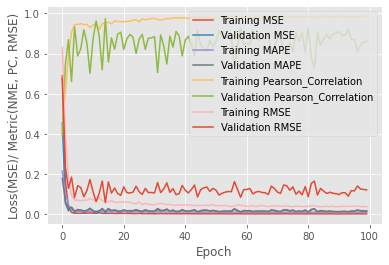

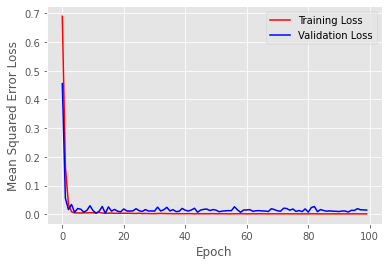

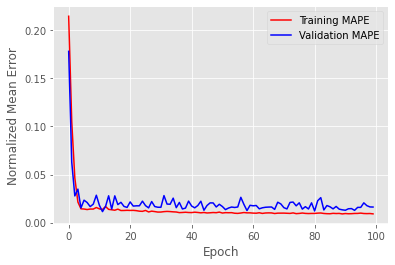

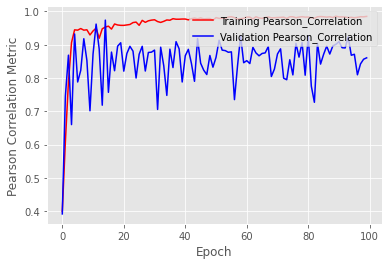

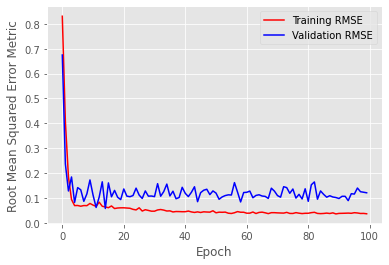

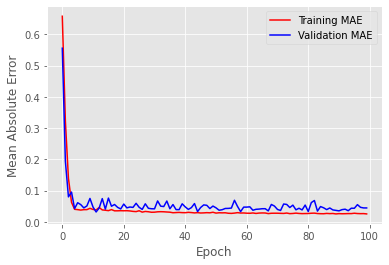

Cropped_resized model total time: 28380.5075


In [6]:
train_images,test_images,val_images=prepare_image()
train_labels, test_labels, val_labels=prepare_label()
train1, test1, val1=combine_labels_images(train_images, train_labels, test_images, test_labels, val_images, val_labels)

def train_model(train, test, val):
    global name1, folder
    
    
    lrelu = keras.layers.LeakyReLU(alpha=0.2)

    baseModel = ResNet152V2(weights="E:/J#4/Data/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5", 
                                include_top=False, input_tensor=Input(shape=(250, 250, 3)))
    baseModel.trainable = True
    headModel = baseModel.output
    # Input dimensions: (None, 250, 250, 32)
    headModel = Conv2D(32, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Conv2D(32, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    #headModel = MaxPooling2D(pool_size=(2, 2))(headModel)

    headModel = Conv2D(64, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Conv2D(64, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    #headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
    #headModel = Dropout(0.25)(headModel)

    headModel = Conv2D(128, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Conv2D(128, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = MaxPooling2D(pool_size=(2, 2))(headModel)

    headModel = Conv2D(250, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Conv2D(250, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    #headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
    #headModel = Dropout(0.25)(headModel)

    headModel = Conv2D(256, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Conv2D(256, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = MaxPooling2D(pool_size=(2, 2))(headModel)

    headModel = Conv2D(512, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Conv2D(512, 3, padding='same', use_bias=False)(headModel)
    headModel = Activation(LeakyReLU(alpha = 0.1))(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
    #headModel = Dropout(0.1)(headModel)
                            
    headModel = Conv2D(36, 1, 1)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Reshape((36,))(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if schedule is not None:
        callbacks = [LearningRateScheduler(schedule)]
        
    loss = tf.keras.losses.MeanSquaredError()
    metrics = [K.eval(custom_loss()), K.eval(custom_metric()), K.eval(correlation_metric()),tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()]
    
    init_lr=1e-3  
    lr = tf.keras.optimizers.schedules.ExponentialDecay(init_lr, decay_steps=100000, decay_rate=0.96, staircase=True)  
    opt = Adam(learning_rate = lr)
    
    model.compile(loss=loss,optimizer=opt,metrics=metrics)
    
    time_callback = TimeHistory()  
    csv_logger = CSVLogger('E:/J#4/Data/Output/AugDS_Models/'+folder+'/'+name_ans+'_'+name1+'_model_on_augDS_logs.csv', append=True)
    checkpoint = keras.callbacks.ModelCheckpoint("E:/J#4/Data/Output/AugDS_Models/"+folder+"/"+name_ans+"_best_"+name1+".hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
    stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
    #callbacks = [EarlyStopping(patience=10, verbose=1),  ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)]
    H = model.fit(train, epochs=epochs, validation_data=val, callbacks=[checkpoint, time_callback, csv_logger, stop])#, callbacks
    time.sleep(0.5)
    model.save("E:/J#4/Data/Output/AugDS_Models/"+folder+"/"+name_ans+'_'+name1+".h5", save_format="h5")
    print(len(H.history['loss']),"------------------------------")
    print("train evaluate:", model.evaluate(train))
    print("val evaluate:", model.evaluate(val))
    print("test evaluate:", model.evaluate(test))
    MSE = tf.keras.losses.MeanSquaredError()                      
    preds_cnn = model.predict(test)
        
    #print(name1, " Model: ", preds_cnn)
    times = time_callback.times 
    #plot_performance(H)
    plot_performance(H)
    return H, times



if __name__ == '__main__':
    time_result = pd.DataFrame(columns=['resize_model_time','crop_resize_model_time'])
    folder="NME"
    name_ans="bs32_lr3"
    
    
    name1="cropped_resized"
    H_, times_=train_model(train1,test1,val1)
    time_result['crop_resize_model_time']=times_
    print("Cropped_resized model total time:", str(round(sum(times_),4)))
    
    writer = pd.ExcelWriter('E:/J#4/Data/Output/AugDS_Models/'+folder+'/'+name_ans+'_'+name1+'_time.xlsx')
    time_result.to_excel(writer)
    writer.save()
        
    
    #plot_loss_time(H, times, H_, times_)   
    
    #print("Crop time:", times_)

In [ ]:
import os.path
import xlsxwriter
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model

workbook = xlsxwriter.Workbook('E:/J#4/Data/Output/AugDS_Models/NME/test_analysis.xlsx')
worksheet = workbook.add_worksheet("Sheet")
worksheet.write(0, 0,  "test_loss(MSE)")
worksheet.write(0, 1,  "test_NME")
worksheet.write(0, 2,  "test_MAPE")
worksheet.write(0, 3,  "test_PC")
worksheet.write(0, 4,  "test_RMSE")
worksheet.write(0, 5,  "test_MAE")
#def custom_loss():        
def NME(y_true, y_pred): 
    y_true = np.array(y_true, dtype="float32")
    y_pred = np.array(y_pred, dtype="float32")
    #y_true = tf.cast(y_true, tf.int32)
    item = K.sqrt(K.sum(K.square(y_true-y_pred), axis=0))
    #_nme = K.mean(item)
    X_Min=10.0
    X_Max=-10.0
    Y_Min=10.0
    Y_Max=-10.0

    for kc in range (36):
        if kc%2==0: 
            X_Min=K.minimum(X_Min, y_true[kc])
            X_Max=K.maximum(X_Max, y_true[kc])
        else: 
            Y_Min=K.minimum(Y_Min, y_true[kc])
            Y_Max=K.maximum(Y_Max, y_true[kc])
    h = Y_Max-Y_Min+24#24
    w = X_Max-X_Min+18#18
    _dist = K.sqrt(h*w)
    temp1 = item/_dist
    _nme = np.mean(temp1)
    return _nme
    #return NME
def MAPE(y_true, y_pred):                     
        #y_true = tf.cast(y_true, tf.int32)
        item = np.sqrt(np.sum(np.square(np.array(y_pred)-np.array(y_true))))
        _mape = np.mean(item)
        return _mape
    
def PC(y_true, y_pred):
        numerator=np.sum((y_true - np.mean(y_true))*(y_pred - np.mean(y_pred)))
        denominator=np.sqrt(np.sum(np.square(y_true - np.mean(y_true))))*np.sqrt(np.sum(np.square(y_pred - np.mean(y_pred))))
        _pc= numerator/denominator
        return _pc
    

model = load_model("E:/J#4/Data/Output/AugDS_Models/NME/bs32_lr3_cropped_resized.h5", custom_objects={'NME': NME, 'MAPE':MAPE,'PC':PC})
i=1
for image in os.listdir('E:/J#4/Data/Preprocessing/DS/OrigDS/test/Real/images_crop'):
    img = cv2.imread(os.path.join('E:/J#4/Data/Preprocessing/DS/OrigDS/test/Real/images_crop', image))
    frame = cv2.resize(img, (250, 250)) 
    img_name=f'{image.split(".")[0]}'
    img_path=os.path.join('E:/J#4/Data/Preprocessing/DS/OrigDS/test/Real/images_crop', image)
    head, tail = os.path.split(img_path)
    file_name = os.path.splitext(tail)[0]
    
    label_path = os.path.join('E:/J#4/Data/Preprocessing/DS/OrigDS/test/Real/labels_crop', file_name+'.json')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)
            #print(label['keypoints'])
    yhat = model.predict(np.expand_dims(frame/255,0))
    sample_coords = yhat[0,:36]
    mse_=np.square(np.subtract(label['keypoints'], sample_coords)).mean()
    mse= mean_squared_error(label['keypoints'], sample_coords, squared=True)
    worksheet.write(i, 0, round(mse,5) )
    nme=NME(label['keypoints'], sample_coords)
    worksheet.write(i, 1, round(nme,5) )
    mape=MAPE(label['keypoints'], sample_coords)
    worksheet.write(i, 2, round(mape,5) )
    pc=PC(label['keypoints'], sample_coords)
    worksheet.write(i, 3, round(pc,5) )
    rmse= mean_squared_error(label['keypoints'], sample_coords, squared=False)
    worksheet.write(i, 4, round(rmse,5) )
    mae=np.mean(np.abs(np.array(label['keypoints']) - np.array(sample_coords)))
    worksheet.write(i, 5, round(mae,5) )
    
    #print(mse,"***",mse_,"***",nme,"***",mape,"***",pc,"***",rmse,"***",mae, i)
    i=i+1
workbook.close()

In [ ]:
import os.path
import xlsxwriter
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model

workbook = xlsxwriter.Workbook('E:/J#4/Data/Output/AugDS_Models/NME/validation_analysis.xlsx')
worksheet = workbook.add_worksheet("Sheet")
worksheet.write(0, 0,  "val_loss(MSE)")
worksheet.write(0, 1,  "val_NME")
worksheet.write(0, 2,  "val_MAPE")
worksheet.write(0, 3,  "val_PC")
worksheet.write(0, 4,  "val_RMSE")
worksheet.write(0, 5,  "val_MAE")
#def custom_loss():        
def NME(y_true, y_pred): 
    y_true = np.array(y_true, dtype="float32")
    y_pred = np.array(y_pred, dtype="float32")
    #y_true = tf.cast(y_true, tf.int32)
    item = K.sqrt(K.sum(K.square(y_true-y_pred), axis=0))
    #_nme = K.mean(item)
    X_Min=10.0
    X_Max=-10.0
    Y_Min=10.0
    Y_Max=-10.0

    for kc in range (36):
        if kc%2==0: 
            X_Min=K.minimum(X_Min, y_true[kc])
            X_Max=K.maximum(X_Max, y_true[kc])
        else: 
            Y_Min=K.minimum(Y_Min, y_true[kc])
            Y_Max=K.maximum(Y_Max, y_true[kc])
    h = Y_Max-Y_Min+24#24
    w = X_Max-X_Min+18#18
    _dist = K.sqrt(h*w)
    temp1 = item/_dist
    _nme = np.mean(temp1)
    return _nme
    #return NME
def MAPE(y_true, y_pred):                     
        #y_true = tf.cast(y_true, tf.int32)
        item = np.sqrt(np.sum(np.square(np.array(y_pred)-np.array(y_true))))
        _mape = np.mean(item)
        return _mape
    
def PC(y_true, y_pred):
        numerator=np.sum((y_true - np.mean(y_true))*(y_pred - np.mean(y_pred)))
        denominator=np.sqrt(np.sum(np.square(y_true - np.mean(y_true))))*np.sqrt(np.sum(np.square(y_pred - np.mean(y_pred))))
        _pc= numerator/denominator
        return _pc
    

model = load_model("E:/J#4/Data/Output/AugDS_Models/NME/bs32_lr3_cropped_resized.h5", custom_objects={'NME': NME, 'MAPE':MAPE,'PC':PC})
i=1
for image in os.listdir('E:/J#4/Data/Preprocessing/DS/OrigDS/val/Real/images_crop'):
    img = cv2.imread(os.path.join('E:/J#4/Data/Preprocessing/DS/OrigDS/val/Real/images_crop', image))
    frame = cv2.resize(img, (250, 250)) 
    img_name=f'{image.split(".")[0]}'
    img_path=os.path.join('E:/J#4/Data/Preprocessing/DS/OrigDS/val/Real/images_crop', image)
    head, tail = os.path.split(img_path)
    file_name = os.path.splitext(tail)[0]
    
    label_path = os.path.join('E:/J#4/Data/Preprocessing/DS/OrigDS/val/Real/labels_crop', file_name+'.json')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)
            #print(label['keypoints'])
    yhat = model.predict(np.expand_dims(frame/255,0))
    sample_coords = yhat[0,:36]
    mse_=np.square(np.subtract(label['keypoints'], sample_coords)).mean()
    mse= mean_squared_error(label['keypoints'], sample_coords, squared=True)
    worksheet.write(i, 0, round(mse,5) )
    nme=NME(label['keypoints'], sample_coords)
    worksheet.write(i, 1, round(nme,5) )
    mape=MAPE(label['keypoints'], sample_coords)
    worksheet.write(i, 2, round(mape,5) )
    pc=PC(label['keypoints'], sample_coords)
    worksheet.write(i, 3, round(pc,5) )
    rmse= mean_squared_error(label['keypoints'], sample_coords, squared=False)
    worksheet.write(i, 4, round(rmse,5) )
    mae=np.mean(np.abs(np.array(label['keypoints']) - np.array(sample_coords)))
    worksheet.write(i, 5, round(mae,5) )
    
    #print(mse,"***",mse_,"***",nme,"***",mape,"***",pc,"***",rmse,"***",mae, i)
    i=i+1
workbook.close()